In [1]:
# Plant Disease Classification using XCiT (Cross-Covariance Image Transformer)
# Complete implementation for Kaggle environment

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [3]:
# Configuration
class Config:
    # Data paths - adjust these according to your Kaggle dataset structure
    TRAIN_DIR = '/kaggle/input/plant-disease-dataset/Dataset_Final_V2_Split/train'
    VAL_DIR = '/kaggle/input/plant-disease-dataset/Dataset_Final_V2_Split/val'
    TEST_DIR = '/kaggle/input/plant-disease-dataset/Dataset_Final_V2_Split/test'
    
    # Model parameters
    MODEL_NAME = 'xcit_nano_12_p16_224'  # XCiT model variant
    IMG_SIZE = 224
    BATCH_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY = 5e-5
    
    # Training parameters
    PATIENCE = 10
    MIN_LR = 1e-7
    FACTOR = 0.5
    
    # Output
    OUTPUT_DIR = '/kaggle/working'
    MODEL_SAVE_PATH = '/kaggle/working/best_xcit_model.pth'

config = Config()


In [4]:
# Data transforms (No augmentation - only basic preprocessing)
def get_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms


In [5]:
# Dataset loading
def load_datasets():
    train_transforms, val_transforms = get_transforms()
    
    # Load datasets
    train_dataset = ImageFolder(root=config.TRAIN_DIR, transform=train_transforms)
    val_dataset = ImageFolder(root=config.VAL_DIR, transform=val_transforms)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Get class names and number of classes
    class_names = train_dataset.classes
    num_classes = len(class_names)
    
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader, num_classes, class_names


In [6]:
# XCiT Model Definition
class XCiTClassifier(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super(XCiTClassifier, self).__init__()
        
        # Load pretrained XCiT model from timm
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,  # Remove classifier head
            global_pool=''  # Remove global pooling
        )
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, config.IMG_SIZE, config.IMG_SIZE)
            features = self.backbone(dummy_input)
            self.feature_dim = features.shape[-1]
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Extract features
        features = self.backbone(x)  # [batch_size, seq_len, feature_dim]
        
        # Apply classifier
        if len(features.shape) == 3:
            features = features.transpose(1, 2)  # [batch_size, feature_dim, seq_len]
        
        output = self.classifier(features)
        return output


In [7]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (inputs, targets) in enumerate(train_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        train_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [8]:
# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    val_bar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            val_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_targets

# Learning rate scheduler with warmup
class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_epochs, max_epochs, base_lr, min_lr=0):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr
        
    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Warmup
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay
            progress = (epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

In [9]:
# Main training function
def train_model():
    # Load data
    train_loader, val_loader, num_classes, class_names = load_datasets()
    
    # Initialize model
    print(f"Initializing {config.MODEL_NAME} model...")
    model = XCiTClassifier(config.MODEL_NAME, num_classes, pretrained=True)
    model = model.to(device)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config.LEARNING_RATE, 
        weight_decay=config.WEIGHT_DECAY
    )
    
    # Learning rate scheduler
    scheduler = WarmupCosineScheduler(
        optimizer, 
        warmup_epochs=5, 
        max_epochs=config.EPOCHS,
        base_lr=config.LEARNING_RATE,
        min_lr=config.MIN_LR
    )
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    print("Starting training...")
    for epoch in range(config.EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.EPOCHS}")
        print("-" * 50)
        
        # Update learning rate
        current_lr = scheduler.step(epoch)
        print(f"Learning rate: {current_lr:.6f}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)
        
        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'class_names': class_names
            }, config.MODEL_SAVE_PATH)
            print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= config.PATIENCE:
            print(f"Early stopping after {epoch+1} epochs")
            break
    
    # Plot training history
    plot_training_history(train_losses, train_accs, val_losses, val_accs)
    
    return model, best_val_acc, class_names

In [10]:
# Plot training history
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_DIR}/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()



In [11]:
# Evaluate model
def evaluate_model(model, val_loader, class_names, device):
    print("Evaluating model...")
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Evaluating'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    
    # Classification report
    report = classification_report(all_targets, all_predictions, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, report, cm


In [12]:
# Prediction function for new images
def predict_image(model, image_path, class_names, device):
    """Predict disease for a single image"""
    _, val_transforms = get_transforms()
    
    # Load and preprocess image
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image = val_transforms(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
        
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    return predicted_class, confidence_score


Plant Disease Classification using XCiT
Number of classes: 51
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Banana___cordana', 'Banana___healthy', 'Banana___pestalotiopsis', 'Banana___sigatoka', 'Bean___angular_leaf_spot', 'Bean___bean_rust', 'Bean___healthy', 'Blueberry___healthy', 'Corn___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn___Common_rust_', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Mango___Anthracnose', 'Mango___Bacterial_Canker', 'Mango___Cutting_Weevil', 'Mango___Die_Back', 'Mango___Gall_Midge', 'Mango___Healthy', 'Mango___Powdery_Mildew', 'Mango___Sooty_Mould', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Rice___bacterial_leaf_blight', 'Rice___brown_spot', 'Rice___healthy', 'Rice___leaf_blast', 'Rice___leaf_s

model.safetensors:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Total parameters: 3,016,435
Trainable parameters: 3,016,435
Starting training...

Epoch 1/50
--------------------------------------------------
Learning rate: 0.000010


Validation: 100%|██████████| 160/160 [00:47<00:00,  3.38it/s, Loss=1.2930, Acc=84.61%]


Train Loss: 2.3918, Train Acc: 51.92%
Val Loss: 1.2930, Val Acc: 84.61%
New best model saved with validation accuracy: 84.61%

Epoch 2/50
--------------------------------------------------
Learning rate: 0.000020


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.46it/s, Loss=0.8882, Acc=94.93%]


Train Loss: 1.1102, Train Acc: 89.50%
Val Loss: 0.8882, Val Acc: 94.93%
New best model saved with validation accuracy: 94.93%

Epoch 3/50
--------------------------------------------------
Learning rate: 0.000030


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.46it/s, Loss=0.8134, Acc=97.26%]


Train Loss: 0.8953, Train Acc: 96.12%
Val Loss: 0.8134, Val Acc: 97.26%
New best model saved with validation accuracy: 97.26%

Epoch 4/50
--------------------------------------------------
Learning rate: 0.000040


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.70it/s, Loss=0.7911, Acc=97.70%]


Train Loss: 0.8295, Train Acc: 98.02%
Val Loss: 0.7911, Val Acc: 97.70%
New best model saved with validation accuracy: 97.70%

Epoch 5/50
--------------------------------------------------
Learning rate: 0.000050


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.58it/s, Loss=0.7693, Acc=98.26%]


Train Loss: 0.8027, Train Acc: 98.59%
Val Loss: 0.7693, Val Acc: 98.26%
New best model saved with validation accuracy: 98.26%

Epoch 6/50
--------------------------------------------------
Learning rate: 0.000050


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.57it/s, Loss=0.7753, Acc=97.86%]


Train Loss: 0.7797, Train Acc: 99.13%
Val Loss: 0.7753, Val Acc: 97.86%

Epoch 7/50
--------------------------------------------------
Learning rate: 0.000050


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.64it/s, Loss=0.7479, Acc=98.87%]


Train Loss: 0.7694, Train Acc: 99.27%
Val Loss: 0.7479, Val Acc: 98.87%
New best model saved with validation accuracy: 98.87%

Epoch 8/50
--------------------------------------------------
Learning rate: 0.000050


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.51it/s, Loss=0.7620, Acc=98.33%]


Train Loss: 0.7585, Train Acc: 99.50%
Val Loss: 0.7620, Val Acc: 98.33%

Epoch 9/50
--------------------------------------------------
Learning rate: 0.000049


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.77it/s, Loss=0.7569, Acc=98.40%]


Train Loss: 0.7555, Train Acc: 99.47%
Val Loss: 0.7569, Val Acc: 98.40%

Epoch 10/50
--------------------------------------------------
Learning rate: 0.000049


Validation: 100%|██████████| 160/160 [00:28<00:00,  5.65it/s, Loss=0.7502, Acc=98.68%]


Train Loss: 0.7488, Train Acc: 99.62%
Val Loss: 0.7502, Val Acc: 98.68%

Epoch 11/50
--------------------------------------------------
Learning rate: 0.000048


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.45it/s, Loss=0.7861, Acc=97.63%]


Train Loss: 0.7446, Train Acc: 99.68%
Val Loss: 0.7861, Val Acc: 97.63%

Epoch 12/50
--------------------------------------------------
Learning rate: 0.000048


Validation: 100%|██████████| 160/160 [00:25<00:00,  6.31it/s, Loss=0.7303, Acc=99.27%]


Train Loss: 0.7439, Train Acc: 99.66%
Val Loss: 0.7303, Val Acc: 99.27%
New best model saved with validation accuracy: 99.27%

Epoch 13/50
--------------------------------------------------
Learning rate: 0.000047


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.89it/s, Loss=0.7320, Acc=99.24%]


Train Loss: 0.7418, Train Acc: 99.69%
Val Loss: 0.7320, Val Acc: 99.24%

Epoch 14/50
--------------------------------------------------
Learning rate: 0.000046


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.63it/s, Loss=0.7331, Acc=99.14%]


Train Loss: 0.7378, Train Acc: 99.75%
Val Loss: 0.7331, Val Acc: 99.14%

Epoch 15/50
--------------------------------------------------
Learning rate: 0.000045


Validation: 100%|██████████| 160/160 [00:25<00:00,  6.32it/s, Loss=0.7343, Acc=99.23%]


Train Loss: 0.7366, Train Acc: 99.76%
Val Loss: 0.7343, Val Acc: 99.23%

Epoch 16/50
--------------------------------------------------
Learning rate: 0.000044


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.63it/s, Loss=0.7283, Acc=99.32%]


Train Loss: 0.7356, Train Acc: 99.77%
Val Loss: 0.7283, Val Acc: 99.32%
New best model saved with validation accuracy: 99.32%

Epoch 17/50
--------------------------------------------------
Learning rate: 0.000043


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.71it/s, Loss=0.7262, Acc=99.43%]


Train Loss: 0.7320, Train Acc: 99.86%
Val Loss: 0.7262, Val Acc: 99.43%
New best model saved with validation accuracy: 99.43%

Epoch 18/50
--------------------------------------------------
Learning rate: 0.000042


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.53it/s, Loss=0.7252, Acc=99.40%]


Train Loss: 0.7336, Train Acc: 99.79%
Val Loss: 0.7252, Val Acc: 99.40%

Epoch 19/50
--------------------------------------------------
Learning rate: 0.000040


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.55it/s, Loss=0.7278, Acc=99.37%]


Train Loss: 0.7305, Train Acc: 99.86%
Val Loss: 0.7278, Val Acc: 99.37%

Epoch 20/50
--------------------------------------------------
Learning rate: 0.000039


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.56it/s, Loss=0.7262, Acc=99.42%]


Train Loss: 0.7283, Train Acc: 99.92%
Val Loss: 0.7262, Val Acc: 99.42%

Epoch 21/50
--------------------------------------------------
Learning rate: 0.000038


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.46it/s, Loss=0.7313, Acc=99.27%]


Train Loss: 0.7315, Train Acc: 99.80%
Val Loss: 0.7313, Val Acc: 99.27%

Epoch 22/50
--------------------------------------------------
Learning rate: 0.000036


Validation: 100%|██████████| 160/160 [00:25<00:00,  6.18it/s, Loss=0.7327, Acc=99.21%]


Train Loss: 0.7272, Train Acc: 99.93%
Val Loss: 0.7327, Val Acc: 99.21%

Epoch 23/50
--------------------------------------------------
Learning rate: 0.000034


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.60it/s, Loss=0.7230, Acc=99.52%]


Train Loss: 0.7270, Train Acc: 99.91%
Val Loss: 0.7230, Val Acc: 99.52%
New best model saved with validation accuracy: 99.52%

Epoch 24/50
--------------------------------------------------
Learning rate: 0.000033


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.65it/s, Loss=0.7311, Acc=99.26%]


Train Loss: 0.7261, Train Acc: 99.92%
Val Loss: 0.7311, Val Acc: 99.26%

Epoch 25/50
--------------------------------------------------
Learning rate: 0.000031


Validation: 100%|██████████| 160/160 [00:27<00:00,  5.79it/s, Loss=0.7264, Acc=99.44%]


Train Loss: 0.7262, Train Acc: 99.92%
Val Loss: 0.7264, Val Acc: 99.44%

Epoch 26/50
--------------------------------------------------
Learning rate: 0.000029


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.70it/s, Loss=0.7278, Acc=99.45%]


Train Loss: 0.7252, Train Acc: 99.94%
Val Loss: 0.7278, Val Acc: 99.45%

Epoch 27/50
--------------------------------------------------
Learning rate: 0.000028


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.94it/s, Loss=0.7215, Acc=99.60%]


Train Loss: 0.7238, Train Acc: 99.97%
Val Loss: 0.7215, Val Acc: 99.60%
New best model saved with validation accuracy: 99.60%

Epoch 28/50
--------------------------------------------------
Learning rate: 0.000026


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.73it/s, Loss=0.7250, Acc=99.49%]


Train Loss: 0.7250, Train Acc: 99.93%
Val Loss: 0.7250, Val Acc: 99.49%

Epoch 29/50
--------------------------------------------------
Learning rate: 0.000024


Validation: 100%|██████████| 160/160 [00:26<00:00,  5.96it/s, Loss=0.7250, Acc=99.54%]


Train Loss: 0.7230, Train Acc: 99.98%
Val Loss: 0.7250, Val Acc: 99.54%

Epoch 30/50
--------------------------------------------------
Learning rate: 0.000022


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.70it/s, Loss=0.7217, Acc=99.62%]


Train Loss: 0.7237, Train Acc: 99.96%
Val Loss: 0.7217, Val Acc: 99.62%
New best model saved with validation accuracy: 99.62%

Epoch 31/50
--------------------------------------------------
Learning rate: 0.000021


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.82it/s, Loss=0.7215, Acc=99.63%]


Train Loss: 0.7238, Train Acc: 99.94%
Val Loss: 0.7215, Val Acc: 99.63%
New best model saved with validation accuracy: 99.63%

Epoch 32/50
--------------------------------------------------
Learning rate: 0.000019


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.50it/s, Loss=0.7210, Acc=99.67%]


Train Loss: 0.7234, Train Acc: 99.95%
Val Loss: 0.7210, Val Acc: 99.67%
New best model saved with validation accuracy: 99.67%

Epoch 33/50
--------------------------------------------------
Learning rate: 0.000017


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.94it/s, Loss=0.7249, Acc=99.59%]


Train Loss: 0.7218, Train Acc: 99.99%
Val Loss: 0.7249, Val Acc: 99.59%

Epoch 34/50
--------------------------------------------------
Learning rate: 0.000016


Validation: 100%|██████████| 160/160 [00:25<00:00,  6.27it/s, Loss=0.7211, Acc=99.68%]


Train Loss: 0.7220, Train Acc: 99.98%
Val Loss: 0.7211, Val Acc: 99.68%
New best model saved with validation accuracy: 99.68%

Epoch 35/50
--------------------------------------------------
Learning rate: 0.000014


Validation: 100%|██████████| 160/160 [00:26<00:00,  5.94it/s, Loss=0.7218, Acc=99.66%]


Train Loss: 0.7212, Train Acc: 100.00%
Val Loss: 0.7218, Val Acc: 99.66%

Epoch 36/50
--------------------------------------------------
Learning rate: 0.000013


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.45it/s, Loss=0.7208, Acc=99.72%]


Train Loss: 0.7212, Train Acc: 100.00%
Val Loss: 0.7208, Val Acc: 99.72%
New best model saved with validation accuracy: 99.72%

Epoch 37/50
--------------------------------------------------
Learning rate: 0.000011


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.87it/s, Loss=0.7208, Acc=99.71%]


Train Loss: 0.7210, Train Acc: 100.00%
Val Loss: 0.7208, Val Acc: 99.71%

Epoch 38/50
--------------------------------------------------
Learning rate: 0.000010


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.91it/s, Loss=0.7212, Acc=99.71%]


Train Loss: 0.7209, Train Acc: 100.00%
Val Loss: 0.7212, Val Acc: 99.71%

Epoch 39/50
--------------------------------------------------
Learning rate: 0.000008


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.93it/s, Loss=0.7201, Acc=99.74%]


Train Loss: 0.7212, Train Acc: 99.99%
Val Loss: 0.7201, Val Acc: 99.74%
New best model saved with validation accuracy: 99.74%

Epoch 40/50
--------------------------------------------------
Learning rate: 0.000007


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.62it/s, Loss=0.7199, Acc=99.73%]


Train Loss: 0.7208, Train Acc: 100.00%
Val Loss: 0.7199, Val Acc: 99.73%

Epoch 41/50
--------------------------------------------------
Learning rate: 0.000006


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.58it/s, Loss=0.7202, Acc=99.77%]


Train Loss: 0.7206, Train Acc: 100.00%
Val Loss: 0.7202, Val Acc: 99.77%
New best model saved with validation accuracy: 99.77%

Epoch 42/50
--------------------------------------------------
Learning rate: 0.000005


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.79it/s, Loss=0.7196, Acc=99.77%]


Train Loss: 0.7206, Train Acc: 100.00%
Val Loss: 0.7196, Val Acc: 99.77%

Epoch 43/50
--------------------------------------------------
Learning rate: 0.000004


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.72it/s, Loss=0.7199, Acc=99.76%]


Train Loss: 0.7206, Train Acc: 100.00%
Val Loss: 0.7199, Val Acc: 99.76%

Epoch 44/50
--------------------------------------------------
Learning rate: 0.000003


Validation: 100%|██████████| 160/160 [00:22<00:00,  6.99it/s, Loss=0.7202, Acc=99.77%]


Train Loss: 0.7205, Train Acc: 100.00%
Val Loss: 0.7202, Val Acc: 99.77%

Epoch 45/50
--------------------------------------------------
Learning rate: 0.000002


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.68it/s, Loss=0.7198, Acc=99.76%]


Train Loss: 0.7204, Train Acc: 100.00%
Val Loss: 0.7198, Val Acc: 99.76%

Epoch 46/50
--------------------------------------------------
Learning rate: 0.000002


Validation: 100%|██████████| 160/160 [00:24<00:00,  6.54it/s, Loss=0.7204, Acc=99.75%]


Train Loss: 0.7205, Train Acc: 100.00%
Val Loss: 0.7204, Val Acc: 99.75%

Epoch 47/50
--------------------------------------------------
Learning rate: 0.000001


Validation: 100%|██████████| 160/160 [00:27<00:00,  5.74it/s, Loss=0.7200, Acc=99.77%]


Train Loss: 0.7203, Train Acc: 100.00%
Val Loss: 0.7200, Val Acc: 99.77%

Epoch 48/50
--------------------------------------------------
Learning rate: 0.000001


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.80it/s, Loss=0.7199, Acc=99.76%]


Train Loss: 0.7204, Train Acc: 100.00%
Val Loss: 0.7199, Val Acc: 99.76%

Epoch 49/50
--------------------------------------------------
Learning rate: 0.000000


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.74it/s, Loss=0.7196, Acc=99.76%]


Train Loss: 0.7203, Train Acc: 100.00%
Val Loss: 0.7196, Val Acc: 99.76%

Epoch 50/50
--------------------------------------------------
Learning rate: 0.000000


Validation: 100%|██████████| 160/160 [00:23<00:00,  6.83it/s, Loss=0.7198, Acc=99.77%]


Train Loss: 0.7203, Train Acc: 100.00%
Val Loss: 0.7198, Val Acc: 99.77%


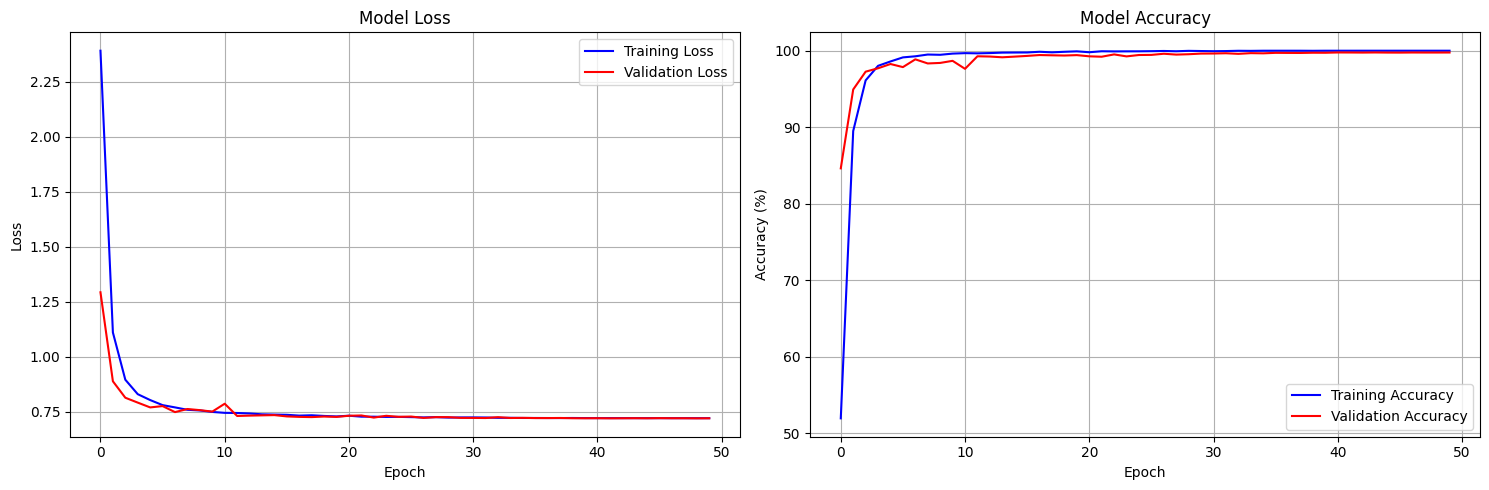

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [13]:
# Main execution
if __name__ == "__main__":
    print("Plant Disease Classification using XCiT")
    print("=" * 50)
    
    # Train the model
    model, best_val_acc, class_names = train_model()
    
    # Load best model for evaluation
    checkpoint = torch.load(config.MODEL_SAVE_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Evaluate model
    _, val_loader, _, _ = load_datasets()
    accuracy, report, cm = evaluate_model(model, val_loader, class_names, device)
    
    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Model saved at: {config.MODEL_SAVE_PATH}")
    
    # Save results
    with open(f'{config.OUTPUT_DIR}/results.txt', 'w') as f:
        f.write(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")
        f.write(f"Final Validation Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    
    print(f"Results saved to: {config.OUTPUT_DIR}/results.txt")